In [19]:
import sys

sys.path.append("..")
import pickle as pkl
from copy import deepcopy
from dataclasses import asdict, is_dataclass
from itertools import product

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dacite import from_dict
from ipywidgets import interact
from scipy.spatial.transform import Rotation

from calibration.benchmark.benchmark import BenchmarkResult
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.projector.board import gen_charuco_grid, gen_checkerboard_grid
from calibration.projector.camera import Camera

# pio.renderers.default = "svg"
from calibration.projector.projector import Projector
from calibration.solver.solve import solve

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open("../simul_results.pkl", "rb") as f:
    results = pkl.load(f)

In [79]:
ts = product([-0.1, 0.1], [-0.1, 0.1], np.arange(-0.2, -0.01, 0.01))
ts = list(map(np.array, ts))
Rs = [np.eye(3), Rotation.from_euler("z", 10, degrees=True).as_matrix()]
Rs = [np.eye(3)]
lambdass = [
    np.array([l1, l2])
    for l1 in np.arange(-1.5, 1.51, 1)
    for l2 in np.arange(
        -2.61752136752137 * l1 - 6.85141810943093,
        -2.61752136752137 * l1 - 4.39190876941320,
        0.5,
    )
]
cameras = [
    Camera(),
    # Camera(135.0, np.array([40, 30]), np.array([1920, 1080]), 1.0),
    Camera(135.0, np.array([40, 30]), np.array([1920, 1080])),
]
boards = [gen_checkerboard_grid(7, 9), gen_charuco_grid(7, 9, 0.4, 0.2)]

results = []
for t, R, lambdas, camera, board in product(ts, Rs, lambdass, cameras, boards):
    proj = Projector(R=R, t=t, lambdas=lambdas, camera=camera)
    try:
        x = proj.project(board)
        if not (x > 0).all():
            rez = 2
        elif not (x < proj.camera.resolution).all():
            rez = 3
        else:
            X_ = proj.backproject(x)
            if np.allclose(X_, board, atol=1e-10):
                rez = 0
            else:
                rez = 4

    except ValueError:
        rez = 1
    results.append(
        dict(
            R=R,
            t=t,
            lambdas=lambdas,
            camera=camera.focal_length == Camera().focal_length,
            rez=str(rez),
        )
    )

In [ ]:
Rs = [
    np.eye(3),
    Rotation.from_euler("z", 10, degrees=True).as_matrix(),
    Rotation.from_euler("xyz", [10, 10, 10], degrees=True).as_matrix(),
]
lambdass = [
    np.array([l1, l2])
    for l1 in np.arange(-1.5, 1.51, 1)
    for l2 in np.arange(
        -2.61752136752137 * l1 - 6.85141810943093,
        -2.61752136752137 * l1 - 4.39190876941320,
        0.5,
    )
]
cameras = [
    Camera(),
    Camera(135.0, np.array([40, 30]), np.array([1920, 1080])),
    Camera(135.0, np.array([40, 30]), np.array([1920, 1080]), 1.0),
]
ts_for_cameras = [
    list(map(np.array, product([-0.1, 0.1], [-0.1, 0.1], [-0.2, -0.01]))),
    list(map(np.array, product([-0.01, 0.01], [-0.01, 0.01], [-0.1, -0.01]))),
    list(map(np.array, product([-0.01, 0.01], [-0.01, 0.01], [-0.1, -0.01]))),
]

results = []
for camera, ts in zip(cameras, ts_for_cameras):
    for R, lambdas, t in tqdm(
        product(Rs, lambdass, ts),
        leave=False,
        total=len(Rs) * len(lambdass) * len(ts),
        desc="Testing benchmark",
    ):
        kwargs = dict(R=R, lambdas=lambdas, t=t, camera=camera)
        try:
            rr = benchmark_simul(100, kwargs=kwargs)
        except ValueError:
            rez = 1
        else:
            for k, v in kwargs.items():
                for r in rr:
                    if isinstance(v, np.ndarray):
                        np.testing.assert_array_equal(getattr(r.input, k), v)
                    else:
                        for f in fields(v):
                            if isinstance(getattr(v, f.name), np.ndarray):
                                np.testing.assert_array_equal(
                                    getattr(v, f.name), getattr(camera, f.name)
                                )
                            else:
                                assert getattr(v, f.name) == getattr(camera, f.name)

            assert None not in rr

In [80]:
df = pd.DataFrame(results)

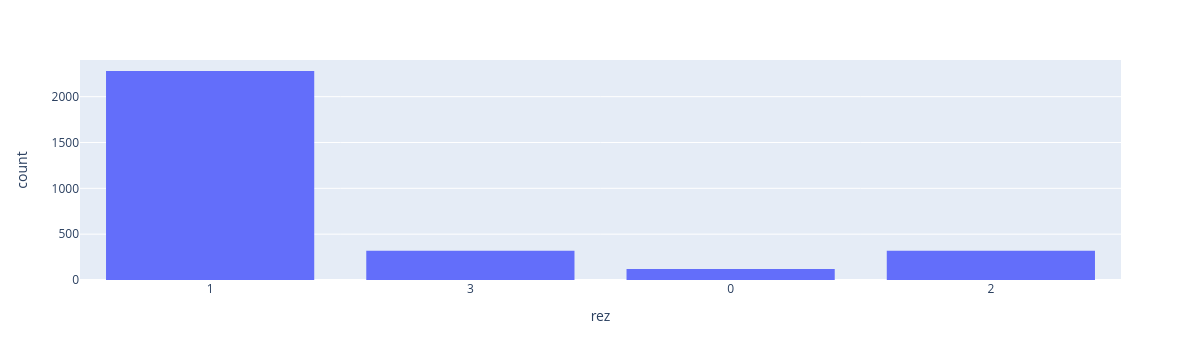

In [90]:
px.histogram(df[df["camera"] == 0], x="rez")

In [92]:
df[(df["camera"] == 0) & (df["rez"] == "0")]["t2"].value_counts()

t2
-0.02    120
Name: count, dtype: int64

In [84]:
for i in range(3):
    for j in range(3):
        df[f"R{i}{j}"] = np.stack(df["R"].values)[:, i, j]
    df[f"t{i}"] = np.stack(df["t"].values)[:, i]
for i in range(2):
    df[f"l{i}"] = np.stack(df["lambdas"].values)[:, i]

df = df.drop(columns=["R", "t", "lambdas"])

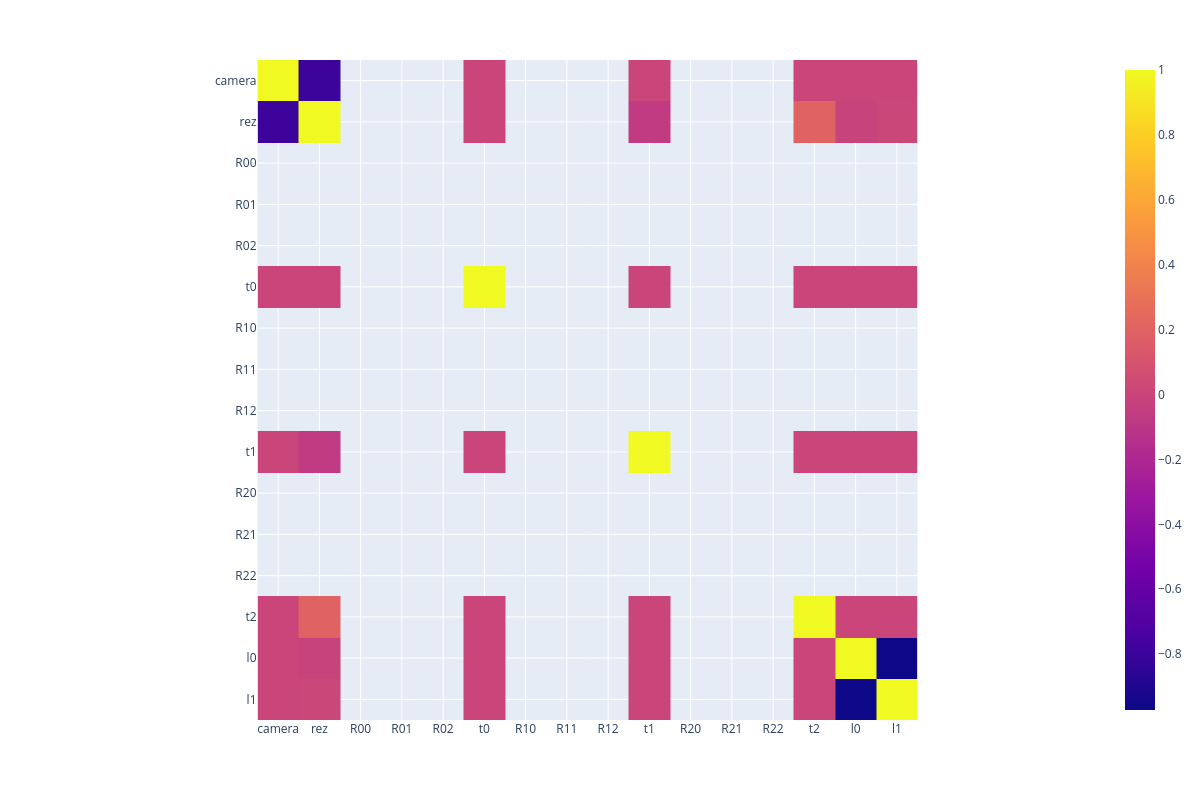

In [85]:
px.imshow(df.corr(), height=800)

In [86]:
df[df["rez"] == "1"]["t2"].value_counts()

t2
-0.20    160
-0.19    160
-0.18    160
-0.17    160
-0.16    160
-0.15    160
-0.14    160
-0.13    160
-0.12    160
-0.11    160
-0.10    160
-0.09    160
-0.08    160
-0.07    120
-0.06     80
Name: count, dtype: int64

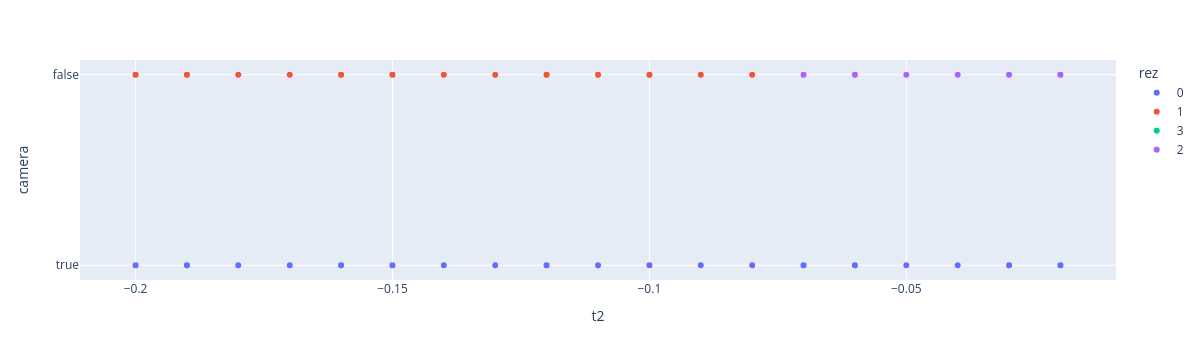

In [87]:
px.scatter(df, y="camera", x="t2", color="rez")